# 0.データ読み込み

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# 秋田のデータ読み込み
aois_akita = gpd.read_file('/workspaces/akita_daizu/data/EVi計算用秋田圃場.geojson')
# 秋田の列名を岐阜と揃える
aois_akita['yield_1'] = aois_akita['15%反収現物重量kg/10a']
aois_akita['type'] = 'リュウホウ'
aois_akita['field_no'] = aois_akita['圃場番号']
# 3mバッファ取った後WGS84に変換
aois_akita['geometry'] = aois_akita.to_crs('epsg:6678').buffer(-3).to_crs('epsg:4326')


In [23]:
# 岐阜のデータ読み込み
aois_gifu = gpd.read_file('/workspaces/akita_daizu/data/gifu_daizu.geojson')
aois_gifu['type'] = 'フクユタカ'
aois_gifu['field_no'] = aois_gifu['Fukue_id']
# 3mバッファ取った後WGS84に変換
aois_gifu['geometry'] = aois_gifu.to_crs('epsg:6675').buffer(-3).to_crs('epsg:4326')


# 1. 衛星画像データの読み込み


## 1-1データの描画確認

In [27]:
import rasterio as rio
tif_path = '/workspaces/akita_daizu/data/gifu_raster/2021-07-13.tiff'
tif =  rio.open(tif_path)

<AxesSubplot:>

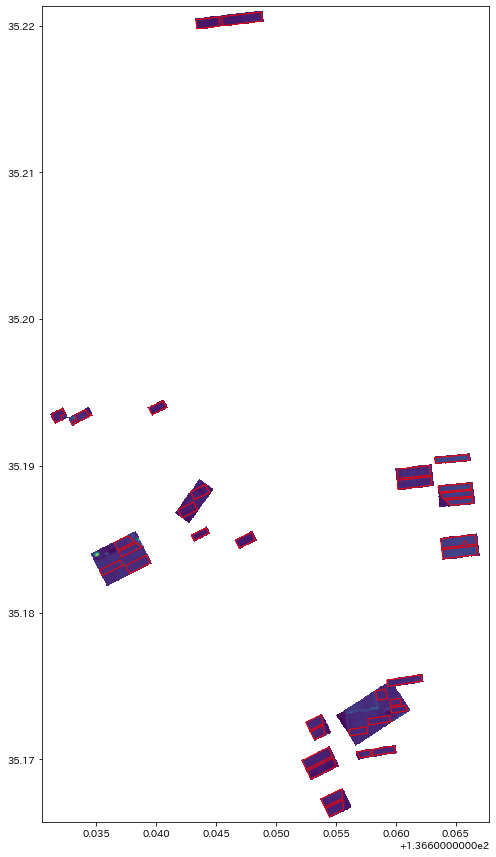

In [28]:
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
raster = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(raster, ax=ax)
aois_gifu.plot(ax=ax, facecolor='none', edgecolor='red')

## 1-2EVI2の作成

In [30]:
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import glob
import os
import numpy as np

In [31]:
# ゆはらさんのコードから　のちに整理する
from rasterio.mask import mask
from vegiindex import evi2
def rio_mask(image, geometry):
    try:
        # all_touched=Trueにすることにより、農地ポリゴンが触れているピクセルの値も取得する
        out_image, _ = mask(image, [geometry], crop=True, all_touched=True, filled=False)
    except ValueError:
        #
        return None
    return out_image
def calc_evi2s(geoms, tif_path):
    with rio.open(tif_path) as image:
        mask_geoms = map(lambda geom: rio_mask(image, geom), geoms)
        _indicies = map(lambda mask_image: None if mask_image is None else evi2(
            mask_image[2], mask_image[3]), mask_geoms)
        _indicies_median = list(map(lambda x: 0 if x is None else np.ma.median(np.ma.masked_invalid(x)), _indicies))
    return np.array(_indicies_median)

In [32]:
# evi　計算する秋田の画像のリスト
data_dir = '/workspaces/akita_daizu/data/raster'
scene_directories = glob.glob(os.path.join(data_dir, '*.tiff'))
# 岐阜のEVI値の取得
for image in scene_directories:
    evi_med = calc_evi2s(aois_akita['geometry'],image)
    image_name = image.split('/')[-1]
    index_name = image_name +'evi2_median'
    aois_akita[index_name] = evi_med

/tmp/ipykernel_15362/3925028207.py:18: UserWarning: Warning: converting a masked element to nan.
  return np.array(_indicies_median)


In [33]:
# evi　計算する岐阜の画像のリスト
data_dir = '/workspaces/akita_daizu/data/gifu_raster'
scene_directories = glob.glob(os.path.join(data_dir, '*.tiff'))
# 岐阜のEVI値の取得
for image in scene_directories:
    evi_med = calc_evi2s(aois_gifu['geometry'],image)
    image_name = image.split('/')[-1]
    index_name = image_name +'evi2_median'
    aois_gifu[index_name] = evi_med

In [34]:
aois_gifu.columns

Index(['耕地の�', 'Fukue_id', 'yield_1', 'geometry', 'type', 'field_no',
       '2021-07-13.tiffevi2_median', '2021-07-19.tiffevi2_median',
       '2021-07-31.tiffevi2_median', '2021-08-27.tiffevi2_median',
       '2021-08-28.tiffevi2_median', '2021-08-31.tiffevi2_median',
       '2021-09-10.tiffevi2_median', '2021-09-15.tiffevi2_median',
       '2021-09-19.tiffevi2_median', '2021-09-23.tiffevi2_median',
       '2021-09-27.tiffevi2_median', '2021-10-02.tiffevi2_median',
       '2021-10-03.tiffevi2_median', '2021-10-04.tiffevi2_median',
       '2021-10-06.tiffevi2_median', '2021-10-14.tiffevi2_median',
       '2021-10-15.tiffevi2_median', '2021-10-23.tiffevi2_median',
       '2021-10-26.tiffevi2_median', '2021-10-28.tiffevi2_median',
       '2021-10-29.tiffevi2_median', '2021-11-02.tiffevi2_median',
       '2021-11-03.tiffevi2_median', '2021-11-05.tiffevi2_median',
       '2021-11-06.tiffevi2_median', '2021-11-08.tiffevi2_median'],
      dtype='object')

In [35]:
aois_akita.columns

Index(['圃場番号', '15%反収現物重量kg/10a', 'geometry', 'yield_1', 'type', 'field_no',
       '2021-06-25.tiffevi2_median', '2021-06-27.tiffevi2_median',
       '2021-06-28.tiffevi2_median', '2021-06-29.tiffevi2_median',
       '2021-06-30.tiffevi2_median', '2021-07-01.tiffevi2_median',
       '2021-07-02.tiffevi2_median', '2021-07-07.tiffevi2_median',
       '2021-07-14.tiffevi2_median', '2021-07-15.tiffevi2_median',
       '2021-07-16.tiffevi2_median', '2021-07-17.tiffevi2_median',
       '2021-07-18.tiffevi2_median', '2021-07-20.tiffevi2_median',
       '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
       '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
       '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
       '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
       '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tif

秋田と岐阜のデータ、画像数も撮影タイミングも品種も違うデータを組み合わせて新しいデータセットを作らないといけない。  
撮影日の若干の違いは無視できるか？　撮影枚数が同じで撮影間隔も同じぐらいの間隔を保てていると良いと思う  
日付が完全に一致してなくてもConcatで並べて、間を線形補完すれば良いか？
Concatの接続パターンと目視接続両パターン作成して、精度比較する

一応目視で感覚合わせたパターンも 作成
秋田のHeatMapの結果も確認して7月末までの画像は全部不要

以下手動作業含まずConcatした場合のデータセット

In [36]:
# Concat用に
aois_gifu_concat = aois_gifu[['field_no', 'type',
    '2021-07-13.tiffevi2_median', '2021-07-19.tiffevi2_median',
    '2021-07-31.tiffevi2_median', '2021-08-27.tiffevi2_median',
    '2021-08-28.tiffevi2_median', '2021-08-31.tiffevi2_median',
    '2021-09-10.tiffevi2_median', '2021-09-15.tiffevi2_median',
    '2021-09-19.tiffevi2_median', '2021-09-23.tiffevi2_median',
    '2021-09-27.tiffevi2_median', '2021-10-02.tiffevi2_median',
    '2021-10-03.tiffevi2_median', '2021-10-04.tiffevi2_median',
    '2021-10-06.tiffevi2_median', '2021-10-14.tiffevi2_median',
    '2021-10-15.tiffevi2_median', '2021-10-23.tiffevi2_median',
    '2021-10-26.tiffevi2_median', '2021-10-28.tiffevi2_median',
    '2021-10-29.tiffevi2_median', '2021-11-02.tiffevi2_median',
    '2021-11-03.tiffevi2_median', '2021-11-05.tiffevi2_median',
    '2021-11-06.tiffevi2_median', '2021-11-08.tiffevi2_median',
    'geometry', 'yield_1', ]]

In [37]:
# concat用に岐阜で撮影できなかった期間を落としたデータセットを作成
aois_akita_concat = aois_akita[['field_no', 'type',
    '2021-07-14.tiffevi2_median', '2021-07-15.tiffevi2_median',
    '2021-07-16.tiffevi2_median', '2021-07-17.tiffevi2_median',
    '2021-07-18.tiffevi2_median', '2021-07-20.tiffevi2_median',
    '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
    '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
    '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
    '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
    '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
    '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
    '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
    '2021-09-03.tiffevi2_median', '2021-09-06.tiffevi2_median',
    '2021-09-07.tiffevi2_median', '2021-09-10.tiffevi2_median',
    '2021-09-12.tiffevi2_median', '2021-09-15.tiffevi2_median',
    '2021-09-19.tiffevi2_median', '2021-09-21.tiffevi2_median',
    '2021-09-25.tiffevi2_median', '2021-09-27.tiffevi2_median',
    '2021-09-28.tiffevi2_median', '2021-10-02.tiffevi2_median',
    '2021-10-03.tiffevi2_median', '2021-10-07.tiffevi2_median',
    '2021-10-09.tiffevi2_median', '2021-10-13.tiffevi2_median',
    '2021-10-24.tiffevi2_median', '2021-10-25.tiffevi2_median',
    '2021-11-01.tiffevi2_median', '2021-11-02.tiffevi2_median',
    '2021-11-06.tiffevi2_median', '2021-11-07.tiffevi2_median',
       'geometry', 'yield_1', ]]


In [38]:
akita_gifu_concat = pd.concat([aois_akita_concat, aois_gifu_concat], ignore_index=True)

In [49]:
akita_gifu_concat_sorted = akita_gifu_concat.sort_index(axis=1)

In [54]:
# soil nameをラベルエンコードする
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(akita_gifu_concat_sorted["type"].values)

#データ変換 リュウホウが1
akita_gifu_concat_sorted["soy_type_CD"] = LE.fit_transform(akita_gifu_concat_sorted["type"].values)
akita_gifu_concat_sorted.drop('type', axis=1)

,field_no,2021-07-13.tiffevi2_median,2021-07-14.tiffevi2_median,2021-07-15.tiffevi2_median,2021-07-16.tiffevi2_median,2021-07-17.tiffevi2_median,2021-07-18.tiffevi2_median,2021-07-19.tiffevi2_median,2021-07-20.tiffevi2_median,2021-07-21.tiffevi2_median,...,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-03.tiffevi2_median,2021-11-05.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,2021-11-08.tiffevi2_median,geometry,yield_1,soy_type_CD
0,1.0,NaN,1.044041,0.884607,0.903078,0.618478,1.203747,NaN,1.291631,0.619813,...,0.000000,0.739951,NaN,NaN,0.763947,0.704509,NaN,"POLYGON ((140.02161 40.26848, 140.02316 40.268...",130.0,1
1,2.0,NaN,0.548337,0.529787,0.698227,0.337090,0.839557,NaN,0.516536,0.359010,...,0.339028,0.692114,NaN,NaN,0.656680,NaN,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",NaN,1
2,3.0,NaN,0.948897,0.854556,0.960789,0.616326,1.052751,NaN,1.544145,0.621093,...,0.386183,0.808646,NaN,NaN,0.770086,NaN,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271...",NaN,1
3,4.0,NaN,0.883469,0.802510,0.779205,0.537051,1.053535,NaN,1.198476,0.597407,...,0.327972,0.763777,NaN,NaN,0.810491,NaN,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271...",NaN,1
4,5.0,NaN,0.873983,0.922222,0.937657,0.681315,1.229874,NaN,0.741524,0.621296,...,0.303694,0.743084,NaN,NaN,0.770290,NaN,NaN,"POLYGON ((140.02119 40.27221, 140.02338 40.272...",138.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Q054,0.838602,NaN,NaN,NaN,NaN,NaN,0.642842,NaN,NaN,...,NaN,0.544421,0.801693,1.352227,1.079825,NaN,0.361592,"POLYGON ((136.64878 35.22092, 136.64886 35.220...",113.5,0
145,M052,0.405251,NaN,NaN,NaN,NaN,NaN,0.699351,NaN,NaN,...,NaN,0.424724,0.576578,0.839165,0.643379,NaN,0.303710,"POLYGON ((136.63531 35.18289, 136.63699 35.183...",89.4,0
146,N032,0.385098,NaN,NaN,NaN,NaN,NaN,0.678665,NaN,NaN,...,NaN,0.660245,0.511543,0.905080,0.696866,NaN,0.259209,"POLYGON ((136.65221 35.16990, 136.65229 35.169...",91.0,0
147,N036,0.412932,NaN,NaN,NaN,NaN,NaN,0.699157,NaN,NaN,...,NaN,0.519010,0.426561,0.703443,0.537669,NaN,0.230160,"POLYGON ((136.65548 35.16798, 136.65556 35.167...",51.5,0


In [55]:
# 秋田と岐阜のデータ組み合わせたGeopandas
akita_gifu_concat_sorted = akita_gifu_concat_sorted[['field_no', 'soy_type_CD',
    '2021-07-13.tiffevi2_median', '2021-07-14.tiffevi2_median',
    '2021-07-15.tiffevi2_median', '2021-07-16.tiffevi2_median',
    '2021-07-17.tiffevi2_median', '2021-07-18.tiffevi2_median',
    '2021-07-19.tiffevi2_median', '2021-07-20.tiffevi2_median',
    '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
    '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
    '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
    '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
    '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
    '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
    '2021-08-20.tiffevi2_median', '2021-08-27.tiffevi2_median',
    '2021-08-28.tiffevi2_median', '2021-08-31.tiffevi2_median',
    '2021-09-02.tiffevi2_median', '2021-09-03.tiffevi2_median',
    '2021-09-06.tiffevi2_median', '2021-09-07.tiffevi2_median',
    '2021-09-10.tiffevi2_median', '2021-09-12.tiffevi2_median',
    '2021-09-15.tiffevi2_median', '2021-09-19.tiffevi2_median',
    '2021-09-21.tiffevi2_median', '2021-09-23.tiffevi2_median',
    '2021-09-25.tiffevi2_median', '2021-09-27.tiffevi2_median',
    '2021-09-28.tiffevi2_median', '2021-10-02.tiffevi2_median',
    '2021-10-03.tiffevi2_median', '2021-10-04.tiffevi2_median',
    '2021-10-06.tiffevi2_median', '2021-10-07.tiffevi2_median',
    '2021-10-09.tiffevi2_median', '2021-10-13.tiffevi2_median',
    '2021-10-14.tiffevi2_median', '2021-10-15.tiffevi2_median',
    '2021-10-23.tiffevi2_median', '2021-10-24.tiffevi2_median',
    '2021-10-25.tiffevi2_median', '2021-10-26.tiffevi2_median',
    '2021-10-28.tiffevi2_median', '2021-10-29.tiffevi2_median',
    '2021-11-01.tiffevi2_median', '2021-11-02.tiffevi2_median',
    '2021-11-03.tiffevi2_median', '2021-11-05.tiffevi2_median',
    '2021-11-06.tiffevi2_median', '2021-11-07.tiffevi2_median',
    '2021-11-08.tiffevi2_median', 'geometry', 
    'yield_1']]

In [57]:
akita_gifu_concat_sorted.to_file('/workspaces/akita_daizu/data/akita_gifu_concat.geojson', driver="GeoJSON") 

以下　手動結合パターン

In [90]:
# 没案　手動で列合わせる手法
#秋田
aois_akita_sort = aois_akita[['field_no','type','yield_1', '2021-07-31.tiffevi2_median',
    '2021-09-02.tiffevi2_median', '2021-09-10.tiffevi2_median', 
    '2021-09-15.tiffevi2_median', '2021-09-19.tiffevi2_median', 
    '2021-09-21.tiffevi2_median', '2021-09-28.tiffevi2_median', 
    '2021-10-02.tiffevi2_median', '2021-10-03.tiffevi2_median', 
    '2021-10-07.tiffevi2_median', '2021-10-13.tiffevi2_median',
    '2021-10-24.tiffevi2_median', '2021-10-25.tiffevi2_median',
    '2021-11-01.tiffevi2_median', '2021-11-02.tiffevi2_median',
    '2021-11-06.tiffevi2_median', '2021-11-07.tiffevi2_median',
    'geometry']]

#岐阜
aois_gifu_sort = aois_gifu[['field_no','type','yield_1', '2021-07-31.tiffevi2_median', 
    '2021-08-31.tiffevi2_median', '2021-09-10.tiffevi2_median', 
    '2021-09-15.tiffevi2_median', '2021-09-19.tiffevi2_median', 
    '2021-09-23.tiffevi2_median', '2021-09-27.tiffevi2_median', 
    '2021-10-02.tiffevi2_median', '2021-10-03.tiffevi2_median', 
    '2021-10-06.tiffevi2_median', '2021-10-14.tiffevi2_median',
    '2021-10-23.tiffevi2_median', '2021-10-26.tiffevi2_median', 
    '2021-11-02.tiffevi2_median', '2021-11-03.tiffevi2_median', 
    '2021-11-06.tiffevi2_median', '2021-11-08.tiffevi2_median',
    'geometry']]

In [91]:
aois_akita_sort.columns = aois_gifu_sort.columns
akita_gifu_concat = pd.concat([aois_akita_sort, aois_gifu_sort], ignore_index=True)

In [92]:
# soil nameをラベルエンコードする
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(akita_gifu_concat["type"].values)

#データ変換 リュウホウが1
akita_gifu_concat["soy_type_CD"] = LE.fit_transform(akita_gifu_concat["type"].values)
akita_gifu_concat.drop('type', axis=1)

,field_no,yield_1,2021-07-31.tiffevi2_median,2021-08-31.tiffevi2_median,2021-09-10.tiffevi2_median,2021-09-15.tiffevi2_median,2021-09-19.tiffevi2_median,2021-09-23.tiffevi2_median,2021-09-27.tiffevi2_median,2021-10-02.tiffevi2_median,...,2021-10-06.tiffevi2_median,2021-10-14.tiffevi2_median,2021-10-23.tiffevi2_median,2021-10-26.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-03.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-08.tiffevi2_median,geometry,soy_type_CD
0,1.0,130.0,1.265322,2.023909,1.614457,1.953490,1.748026,1.685594,0.000000,1.224386,...,1.475540,1.381364,1.082733,0.858694,0.000000,0.739951,0.763947,0.704509,"POLYGON ((140.02161 40.26848, 140.02316 40.268...",1
1,2.0,NaN,0.536568,0.850010,0.700379,0.943962,0.790507,1.075969,0.000000,0.663917,...,0.817294,0.891004,0.926511,0.646824,0.339028,0.692114,0.656680,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",1
2,3.0,NaN,1.057181,1.246958,1.084487,1.508682,1.311399,1.565851,0.000000,0.984066,...,1.151325,1.162275,1.099369,0.807891,0.386183,0.808646,0.770086,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271...",1
3,4.0,NaN,1.407967,2.076154,1.676602,2.023044,1.835926,1.775448,0.000000,1.338692,...,1.522230,1.404911,1.091886,0.843803,0.327972,0.763777,0.810491,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271...",1
4,5.0,138.0,1.419072,2.105967,1.702135,1.967038,1.803499,1.724467,0.000000,1.309426,...,1.465884,1.389429,1.044171,0.858294,0.303694,0.743084,0.770290,NaN,"POLYGON ((140.02119 40.27221, 140.02338 40.272...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Q054,113.5,0.000000,0.648429,1.484811,0.990033,1.358244,1.646669,1.809831,1.772791,...,1.605282,1.379801,1.027161,1.624725,0.544421,0.801693,1.079825,0.361592,"POLYGON ((136.64878 35.22092, 136.64886 35.220...",0
145,M052,89.4,0.670396,1.821274,2.136543,0.434954,1.690551,1.969099,1.846822,1.986390,...,1.817423,1.319682,1.306797,1.209772,0.424724,0.576578,0.643379,0.303710,"POLYGON ((136.63531 35.18289, 136.63699 35.183...",0
146,N032,91.0,0.486986,1.498931,1.949824,1.216786,1.732913,1.827479,1.711049,1.849646,...,1.649593,1.165690,1.168729,1.119820,0.660245,0.511543,0.696866,0.259209,"POLYGON ((136.65221 35.16990, 136.65229 35.169...",0
147,N036,51.5,0.570533,2.027492,2.189895,1.466192,1.950162,1.975110,1.775655,1.986278,...,1.808119,1.218477,0.931841,0.958941,0.519010,0.426561,0.537669,0.230160,"POLYGON ((136.65548 35.16798, 136.65556 35.167...",0


In [213]:
akita_gifu_concat = akita_gifu_concat[[
        'field_no', 'soy_type_CD',  
        '2021-07-31.tiffevi2_median',
        '2021-08-31.tiffevi2_median', '2021-09-10.tiffevi2_median',
        '2021-09-15.tiffevi2_median', '2021-09-19.tiffevi2_median',
        '2021-09-23.tiffevi2_median', '2021-09-27.tiffevi2_median',
        '2021-10-02.tiffevi2_median', '2021-10-03.tiffevi2_median',
        '2021-10-06.tiffevi2_median', '2021-10-14.tiffevi2_median',
        '2021-10-23.tiffevi2_median', '2021-10-26.tiffevi2_median',
        '2021-11-02.tiffevi2_median', '2021-11-03.tiffevi2_median',
        '2021-11-06.tiffevi2_median', '2021-11-08.tiffevi2_median', 
        'geometry','yield_1']]

In [214]:
# 結果の保存
akita_gifu_concat.to_file('/workspaces/akita_daizu/data/akita_gifu_syudou_concat.geojson', driver="GeoJSON") 

# 2 EVIによる収量の予測

## 2-1 データの補間

In [233]:
evi_yield = gpd.read_file('/workspaces/akita_daizu/data/akita_gifu_syudou_concat.geojson')

In [234]:
# gpdだと処理できない部分があるのでDF化
evi_yield = pd.DataFrame(evi_yield)

In [235]:
# 面積間違いにより終了が異常に高くなってしまっている圃場の除去
# 面積に誤りがある反収を取り除く。圃場番号7　反収251の圃場は実面積の半分ほどの面積で計算されている
evi_yield = evi_yield[evi_yield['field_no']!='7']

In [236]:
# null check
print(evi_yield.isnull().sum())

field_no                       0
soy_type_CD                    0
2021-07-31.tiffevi2_median     0
2021-08-31.tiffevi2_median     0
2021-09-10.tiffevi2_median     0
2021-09-15.tiffevi2_median     0
2021-09-19.tiffevi2_median     0
2021-09-23.tiffevi2_median     0
2021-09-27.tiffevi2_median     0
2021-10-02.tiffevi2_median     0
2021-10-03.tiffevi2_median     0
2021-10-06.tiffevi2_median    52
2021-10-14.tiffevi2_median     0
2021-10-23.tiffevi2_median     0
2021-10-26.tiffevi2_median     0
2021-11-02.tiffevi2_median    43
2021-11-03.tiffevi2_median     0
2021-11-06.tiffevi2_median     0
2021-11-08.tiffevi2_median    84
yield_1                       83
geometry                       0
dtype: int64


In [237]:
# nullのチェック　前後の時期のデータから線形補間が必要
# EVIが0の値をNanに変換
interpo_evi = evi_yield
interpo_evi.iloc[:,2:-2] = interpo_evi.iloc[:,2:-2].replace(0,np.nan)

In [238]:
# 圃場番号、収量、Geometry除いて、EVIだけで補間する
interpo_evi.iloc[:,2:-2] = interpo_evi.iloc[:,2:-2].interpolate(method='linear',axis=1)

In [239]:
interpo_evi.iloc[0:1,2:-2]

,2021-07-31.tiffevi2_median,2021-08-31.tiffevi2_median,2021-09-10.tiffevi2_median,2021-09-15.tiffevi2_median,2021-09-19.tiffevi2_median,2021-09-23.tiffevi2_median,2021-09-27.tiffevi2_median,2021-10-02.tiffevi2_median,2021-10-03.tiffevi2_median,2021-10-06.tiffevi2_median,2021-10-14.tiffevi2_median,2021-10-23.tiffevi2_median,2021-10-26.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-03.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-08.tiffevi2_median
0,1.265322,2.023909,1.614457,1.95349,1.748026,1.685594,1.45499,1.224386,1.491586,1.47554,1.381364,1.082733,0.858694,0.799323,0.739951,0.763947,0.704509


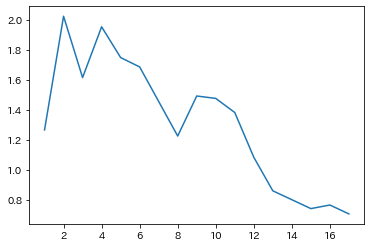

In [240]:
import numpy as np
import matplotlib.pyplot as plt
x_length = len(interpo_evi.iloc[0:1,2:-2].columns)
# 折れ線グラフを出力
x_plot = np.linspace(1,x_length, x_length) 
y_plot = interpo_evi.iloc[0:1,2:-2].values.T
plt.plot(x_plot, y_plot)

In [241]:
type(interpo_evi)

pandas.core.frame.DataFrame

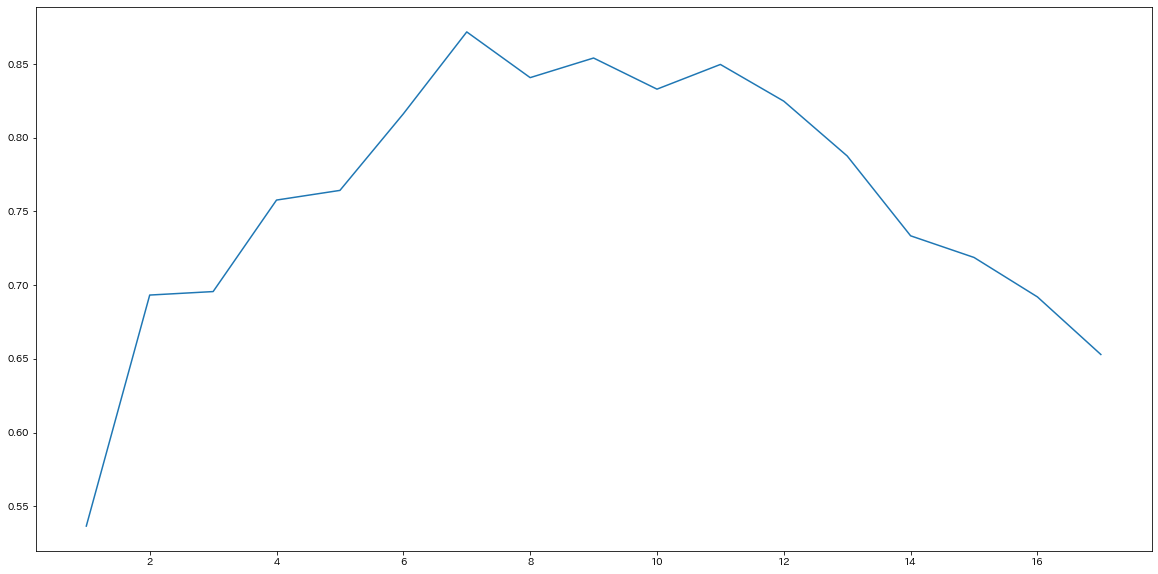

In [242]:
# 移動平均を取った場合を確認 rolling6　ぐらいにするとやっと下降するグラフは消える。　そもそも雲を消す方が優先。

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
rolled_evi = interpo_evi.copy()
 
# 折れ線グラフを出力 
rolled_evi.iloc[:,2:-2] = rolled_evi.iloc[:,2:-2].rolling(6, min_periods=1, axis=1).mean()
y_plot = rolled_evi.iloc[1,2:-2].values.T
plt.plot(x_plot, y_plot)


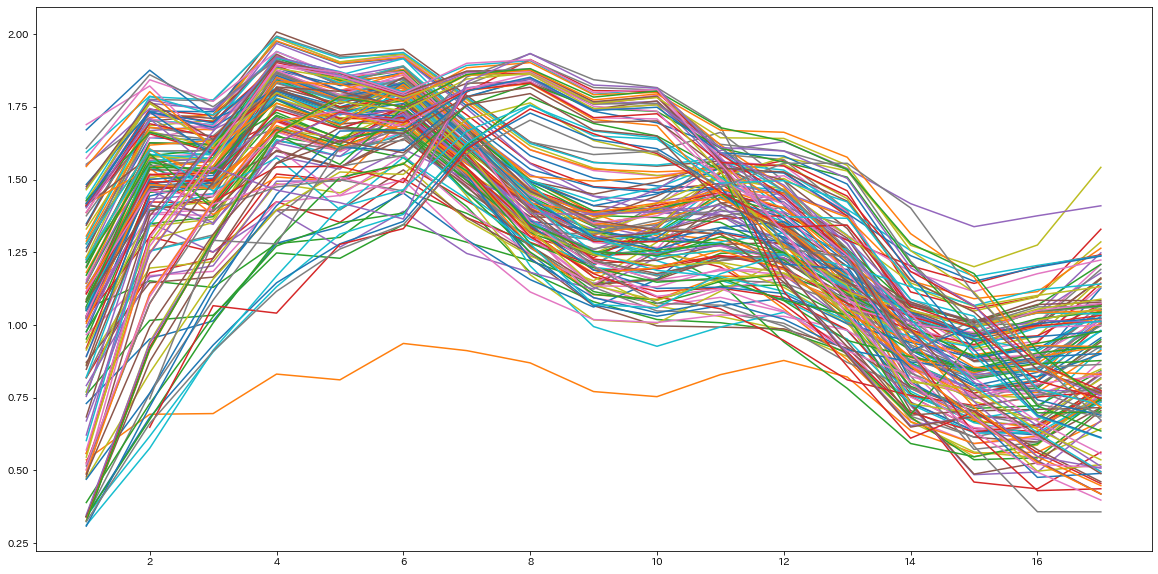

In [243]:
# 全圃場の表示 と　全圃場のRolling

rolled_evi = interpo_evi.copy()
rolled_evi.iloc[:,2:-2] = interpo_evi.iloc[:,2:-2].rolling(3, min_periods=1, axis=1).mean()
y_plot = rolled_evi.iloc[1,2:-2].values.T

plt.figure(figsize=(20,10))

for i in range(rolled_evi.iloc[:,2:-2].shape[0]):
    y_plot = rolled_evi.iloc[i,2:-2].values.T
    plt.plot(x_plot, y_plot,label="圃場番号" + str(rolled_evi.iloc[i,0]))
    # plt.legend() # (3)凡例表示

    
plt.show()

In [244]:
rolled_evi

,field_no,soy_type_CD,2021-07-31.tiffevi2_median,2021-08-31.tiffevi2_median,2021-09-10.tiffevi2_median,2021-09-15.tiffevi2_median,2021-09-19.tiffevi2_median,2021-09-23.tiffevi2_median,2021-09-27.tiffevi2_median,2021-10-02.tiffevi2_median,...,2021-10-06.tiffevi2_median,2021-10-14.tiffevi2_median,2021-10-23.tiffevi2_median,2021-10-26.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-03.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-08.tiffevi2_median,yield_1,geometry
0,1,1,1.265322,1.644615,1.634562,1.863952,1.771991,1.795703,1.629537,1.454990,...,1.397171,1.449497,1.313212,1.107597,0.913583,0.799323,0.767740,0.736136,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268..."
1,2,1,0.536568,0.693289,0.695653,0.831450,0.811616,0.936813,0.912140,0.869943,...,0.753803,0.829498,0.878270,0.821446,0.637454,0.559322,0.562607,0.668491,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271..."
2,3,1,1.057181,1.152070,1.129542,1.280042,1.301523,1.461977,1.384069,1.274958,...,1.074032,1.133435,1.137656,1.023178,0.764481,0.667573,0.654972,0.782939,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271..."
3,4,1,1.407967,1.742061,1.720241,1.925267,1.845191,1.878139,1.722814,1.557070,...,1.464482,1.486555,1.339676,1.113533,0.754553,0.645184,0.634080,0.794920,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271..."
4,5,1,1.419072,1.762519,1.742391,1.925046,1.824224,1.831668,1.681637,1.516946,...,1.425901,1.452569,1.299828,1.097298,0.735387,0.635024,0.605690,0.761222,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Q054,0,NaN,0.648429,1.066620,1.041091,1.277696,1.331649,1.604915,1.743097,...,1.589719,1.458722,1.337415,1.343896,1.065436,0.990280,0.808646,0.747703,113.5,"POLYGON ((136.64878 35.22092, 136.64886 35.220..."
145,M052,0,0.670396,1.245835,1.542738,1.464257,1.420683,1.364868,1.835491,1.934103,...,1.815557,1.593322,1.481301,1.278750,0.980431,0.737025,0.548227,0.507889,89.4,"POLYGON ((136.63531 35.18289, 136.63699 35.183..."
146,N032,0,0.486986,0.992958,1.311914,1.555180,1.633175,1.592393,1.757147,1.796058,...,1.649758,1.421772,1.328004,1.151413,0.982931,0.763869,0.622885,0.489206,91.0,"POLYGON ((136.65221 35.16990, 136.65229 35.169..."
147,N036,0,0.570533,1.299013,1.595973,1.894526,1.868750,1.797155,1.900309,1.912348,...,1.810507,1.554573,1.319479,1.036420,0.803264,0.634837,0.494413,0.398130,51.5,"POLYGON ((136.65548 35.16798, 136.65556 35.167..."


In [245]:
interpo_evi.dropna(subset=['yield_1'])

,field_no,soy_type_CD,2021-07-31.tiffevi2_median,2021-08-31.tiffevi2_median,2021-09-10.tiffevi2_median,2021-09-15.tiffevi2_median,2021-09-19.tiffevi2_median,2021-09-23.tiffevi2_median,2021-09-27.tiffevi2_median,2021-10-02.tiffevi2_median,...,2021-10-06.tiffevi2_median,2021-10-14.tiffevi2_median,2021-10-23.tiffevi2_median,2021-10-26.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-03.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-08.tiffevi2_median,yield_1,geometry
0,1,1,1.265322,2.023909,1.614457,1.953490,1.748026,1.685594,1.454990,1.224386,...,1.475540,1.381364,1.082733,0.858694,0.799323,0.739951,0.763947,0.704509,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268..."
4,5,1,1.419072,2.105967,1.702135,1.967038,1.803499,1.724467,1.516946,1.309426,...,1.465884,1.389429,1.044171,0.858294,0.303694,0.743084,0.770290,0.770290,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272..."
8,8,1,1.419511,2.132724,1.761785,2.086919,1.917579,1.792337,1.628894,1.465451,...,1.664596,1.658796,1.165609,0.883040,0.463888,0.737019,0.756262,0.756262,162.0,"POLYGON ((140.02314 40.27434, 140.02316 40.274..."
10,10,1,1.436701,2.133492,1.752671,2.084698,1.914935,1.812544,1.624397,1.436249,...,1.598057,1.507872,1.061347,0.856942,0.398814,0.736853,0.733526,0.733526,164.0,"POLYGON ((140.02158 40.27552, 140.02315 40.275..."
26,27,1,1.202024,2.050418,1.612582,1.962259,1.761019,1.534416,1.201981,0.955885,...,0.993093,0.943711,1.024336,0.792533,0.368301,0.302088,0.908701,0.908701,157.0,"POLYGON ((140.06002 40.28557, 140.06006 40.285..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Q054,0,NaN,0.648429,1.484811,0.990033,1.358244,1.646669,1.809831,1.772791,...,1.605282,1.379801,1.027161,1.624725,0.544421,0.801693,1.079825,0.361592,113.5,"POLYGON ((136.64878 35.22092, 136.64886 35.220..."
145,M052,0,0.670396,1.821274,2.136543,0.434954,1.690551,1.969099,1.846822,1.986390,...,1.817423,1.319682,1.306797,1.209772,0.424724,0.576578,0.643379,0.303710,89.4,"POLYGON ((136.63531 35.18289, 136.63699 35.183..."
146,N032,0,0.486986,1.498931,1.949824,1.216786,1.732913,1.827479,1.711049,1.849646,...,1.649593,1.165690,1.168729,1.119820,0.660245,0.511543,0.696866,0.259209,91.0,"POLYGON ((136.65221 35.16990, 136.65229 35.169..."
147,N036,0,0.570533,2.027492,2.189895,1.466192,1.950162,1.975110,1.775655,1.986278,...,1.808119,1.218477,0.931841,0.958941,0.519010,0.426561,0.537669,0.230160,51.5,"POLYGON ((136.65548 35.16798, 136.65556 35.167..."


TypeError: float() argument must be a string or a number, not 'Polygon'

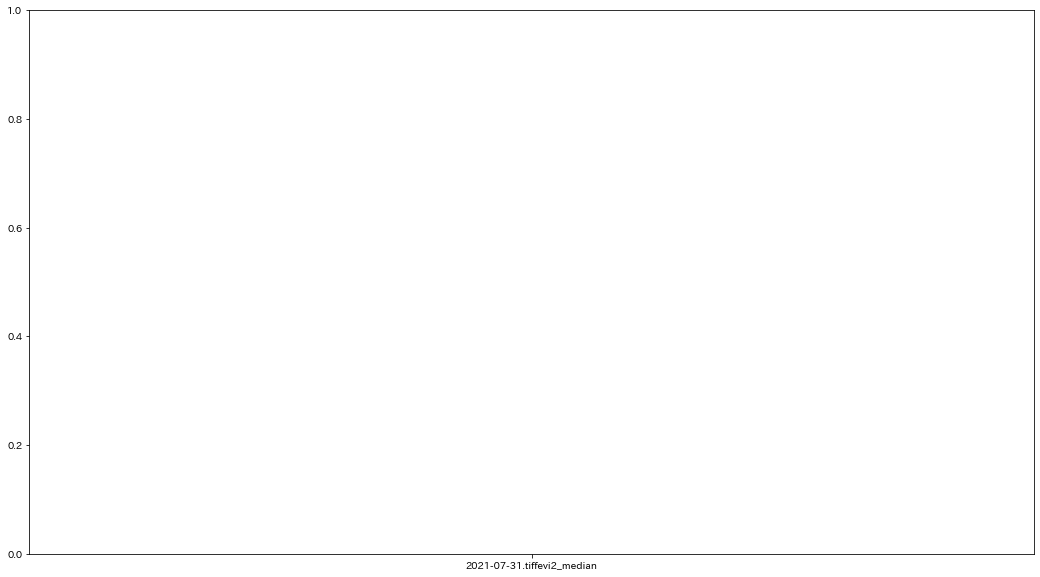

In [246]:
# 収量のあるデータだけで表示
interpo_evi_yield= interpo_evi.dropna(subset=['yield_1'])

#全期間見る時は.iloc[:,1:-2]　EVI最大値あたりは　25:33
slice_a = 2
slice_b = 33
x_plot = interpo_evi.iloc[:,slice_a:slice_b].columns
rolled_evi = interpo_evi.copy()

rolled_yield_evi = interpo_evi_yield.copy()
rolled_yield_evi.iloc[:,2:-2] = interpo_evi.iloc[:,2:-2].rolling(3, min_periods=1, axis=1).mean()

plt.figure(figsize=(18,10))
# 31圃場見ると見づらいのでRangeで数指定
for i in range(1,51):
    y_plot = rolled_yield_evi.iloc[i,slice_a:slice_b].values.T
    plt.plot(x_plot, y_plot,label="圃場番号" + str(rolled_yield_evi.iloc[i,0]))
    plt.legend(fontsize = 10) # (3)凡例表示
    plt.xticks(rotation=90)

plt.show()

一通りプロットした結果 　EVIの時系列変化と収量の考察  
* 今の時系列EVI全て与えても　場所によって雲でEVI値が降下してしまう場所もあるので危険  
* 時系列で全ての画像を利用する際には必ず雲のある地点はNull値として除外する処理が必須。
* 雲をNullで除外できていれば移動平均をしても以前の値より下がるようなことはないはず。　次回検証
* 収量との相関確認して、相関高いところだけ抽出して重回帰を行う。
    * できれば生育初期と末期の植生指数の推移も説明変数として入れたいが、雲の影響を評価しきれないので相関高いところだけで検討する

In [247]:
# rollingで移動平均を取る
rolled_evi = interpo_evi.copy()
rolled_evi.iloc[:,1:-2] = interpo_evi.iloc[:,1:-2].rolling(6, min_periods=1, axis=1).mean()

In [248]:
# 収量以外Nullなしのデータ完成
print(rolled_evi.isnull().sum())

field_no                       0
soy_type_CD                    0
2021-07-31.tiffevi2_median     0
2021-08-31.tiffevi2_median     0
2021-09-10.tiffevi2_median     0
2021-09-15.tiffevi2_median     0
2021-09-19.tiffevi2_median     0
2021-09-23.tiffevi2_median     0
2021-09-27.tiffevi2_median     0
2021-10-02.tiffevi2_median     0
2021-10-03.tiffevi2_median     0
2021-10-06.tiffevi2_median     0
2021-10-14.tiffevi2_median     0
2021-10-23.tiffevi2_median     0
2021-10-26.tiffevi2_median     0
2021-11-02.tiffevi2_median     0
2021-11-03.tiffevi2_median     0
2021-11-06.tiffevi2_median     0
2021-11-08.tiffevi2_median     0
yield_1                       83
geometry                       0
dtype: int64


In [249]:
#　どっちのデータで出力しているか用確認
# rolled_evi.to_csv('/workspaces/akita_daizu/data/akita_gifu_EVI_concat.csv')
# rolled_evi.to_csv('/workspaces/akita_daizu/data/akita_gifu_all_EVI_concat.csv')

In [126]:
rolled_evi

,field_no,soy_type_CD,2021-07-31.tiffevi2_median,2021-08-31.tiffevi2_median,2021-09-10.tiffevi2_median,2021-09-15.tiffevi2_median,2021-09-19.tiffevi2_median,2021-09-23.tiffevi2_median,2021-09-27.tiffevi2_median,2021-10-02.tiffevi2_median,...,2021-10-06.tiffevi2_median,2021-10-14.tiffevi2_median,2021-10-23.tiffevi2_median,2021-10-26.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-03.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-08.tiffevi2_median,yield_1,geometry
0,1,1.0,1.132661,1.429744,1.475922,1.571436,1.600867,1.715133,1.504246,1.370992,...,1.270855,1.209745,1.109268,1.252384,1.048320,0.923047,0.804448,0.691639,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268..."
1,2,1.0,0.768284,0.795526,0.771739,0.806184,0.803571,0.816233,0.726805,0.695789,...,0.687981,0.704730,0.679820,0.787624,0.733476,0.718796,0.692027,0.652973,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271..."
2,3,1.0,1.028591,1.101380,1.097157,1.179462,1.201451,1.295760,1.119563,1.075747,...,1.016558,0.991704,0.913956,1.048605,0.948958,0.902615,0.839075,0.773710,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271..."
3,4,1.0,1.203984,1.494707,1.540181,1.636753,1.669949,1.799190,1.564529,1.441619,...,1.334137,1.262301,1.148374,1.289008,1.120554,0.992430,0.873807,0.774737,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271..."
4,5,1.0,1.209536,1.508346,1.556793,1.638842,1.666285,1.787029,1.550517,1.417761,...,1.300945,1.231933,1.118551,1.261600,1.093978,0.967426,0.851494,0.748304,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Q054,0.0,0.000000,0.216143,0.533310,0.624655,0.746919,1.021364,1.323003,1.510396,...,1.597317,1.600910,1.497658,1.466807,1.262079,1.163847,1.076271,0.906570,113.5,"POLYGON ((136.64878 35.22092, 136.64886 35.220..."
145,M052,0.0,0.335198,0.830557,1.157053,1.012633,1.125620,1.453803,1.649874,1.677393,...,1.825524,1.763713,1.653329,1.547154,1.286876,1.109163,0.913489,0.744160,89.4,"POLYGON ((136.63531 35.18289, 136.63699 35.183..."
146,N032,0.0,0.243493,0.661972,0.983935,1.030505,1.147573,1.452153,1.656164,1.714616,...,1.703452,1.608915,1.499123,1.400585,1.202352,1.045937,0.887149,0.736069,91.0,"POLYGON ((136.65221 35.16990, 136.65229 35.169..."
147,N036,0.0,0.285267,0.866008,1.196980,1.250823,1.367379,1.696564,1.897418,1.890549,...,1.855408,1.733460,1.559582,1.423463,1.178918,0.977158,0.765416,0.600697,51.5,"POLYGON ((136.65548 35.16798, 136.65556 35.167..."


## 2-2　収量予測

### 2-2-0 相関確認

In [398]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [399]:
rolled_evi_yield.columns

Index(['圃場番号', '2021-06-25.tiffevi2_median', '2021-06-27.tiffevi2_median',
       '2021-06-28.tiffevi2_median', '2021-06-29.tiffevi2_median',
       '2021-06-30.tiffevi2_median', '2021-07-01.tiffevi2_median',
       '2021-07-02.tiffevi2_median', '2021-07-07.tiffevi2_median',
       '2021-07-14.tiffevi2_median', '2021-07-15.tiffevi2_median',
       '2021-07-16.tiffevi2_median', '2021-07-17.tiffevi2_median',
       '2021-07-18.tiffevi2_median', '2021-07-20.tiffevi2_median',
       '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
       '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
       '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
       '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
       '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffe

In [400]:
rolled_evi_yield_dropped = rolled_evi_yield[['2021-06-25.tiffevi2_median', '2021-06-27.tiffevi2_median',
       '2021-06-28.tiffevi2_median', '2021-06-29.tiffevi2_median',
       '2021-06-30.tiffevi2_median', '2021-07-01.tiffevi2_median',
       '2021-07-02.tiffevi2_median', '2021-07-07.tiffevi2_median',
       '2021-07-14.tiffevi2_median', '2021-07-15.tiffevi2_median',
       '2021-07-16.tiffevi2_median', '2021-07-17.tiffevi2_median',
       '2021-07-18.tiffevi2_median', '2021-07-20.tiffevi2_median',
       '2021-07-21.tiffevi2_median', '2021-07-24.tiffevi2_median',
       '2021-07-25.tiffevi2_median', '2021-07-26.tiffevi2_median',
       '2021-07-30.tiffevi2_median', '2021-07-31.tiffevi2_median',
       '2021-08-02.tiffevi2_median', '2021-08-03.tiffevi2_median',
       '2021-08-05.tiffevi2_median', '2021-08-06.tiffevi2_median',
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffevi2_median',
       '2021-09-07.tiffevi2_median', '2021-09-10.tiffevi2_median',
       '2021-09-12.tiffevi2_median', '2021-09-15.tiffevi2_median',
       '2021-09-19.tiffevi2_median', '2021-09-21.tiffevi2_median',
       '2021-09-25.tiffevi2_median', '2021-09-27.tiffevi2_median',
       '2021-09-28.tiffevi2_median', '2021-10-02.tiffevi2_median',
       '2021-10-03.tiffevi2_median', '2021-10-07.tiffevi2_median',
       '2021-10-09.tiffevi2_median', '2021-10-13.tiffevi2_median',
       '2021-10-24.tiffevi2_median', '2021-10-25.tiffevi2_median',
       '2021-11-01.tiffevi2_median', '2021-11-02.tiffevi2_median',
       '2021-11-06.tiffevi2_median', '2021-11-07.tiffevi2_median',
       '15%反収現物重量kg/10a']]

In [401]:
corr = rolled_evi_yield_dropped.corr()

<AxesSubplot:>

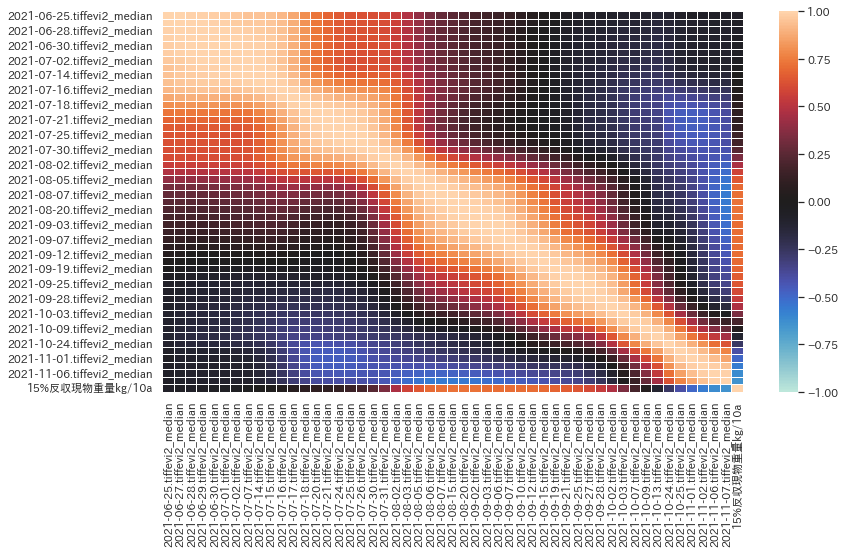

In [404]:
# sns　setするとフォントもデフォルトのsans serifになって文字化けするから、Plotサイズ変える時にフォントも指定する
sns.set(rc = {'figure.figsize':(13,7)},font='IPAexGothic')
sns.heatmap(corr, vmax=1, vmin=-1, center=0,linewidths=.5)

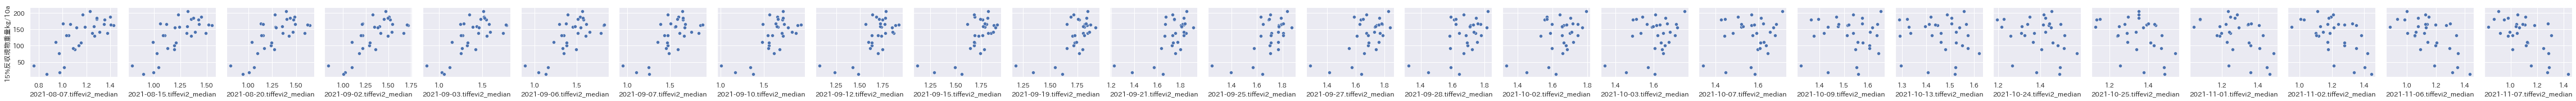

In [571]:
sns.pairplot(rolled_evi_yield_dropped, x_vars=[
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffevi2_median',
        '2021-09-07.tiffevi2_median', '2021-09-10.tiffevi2_median',
       '2021-09-12.tiffevi2_median', '2021-09-15.tiffevi2_median',
       '2021-09-19.tiffevi2_median', '2021-09-21.tiffevi2_median',
       '2021-09-25.tiffevi2_median', '2021-09-27.tiffevi2_median',
       '2021-09-28.tiffevi2_median', '2021-10-02.tiffevi2_median',
       '2021-10-03.tiffevi2_median', '2021-10-07.tiffevi2_median',
       '2021-10-09.tiffevi2_median', '2021-10-13.tiffevi2_median',
       '2021-10-24.tiffevi2_median', '2021-10-25.tiffevi2_median',
       '2021-11-01.tiffevi2_median', '2021-11-02.tiffevi2_median',
       '2021-11-06.tiffevi2_median', '2021-11-07.tiffevi2_median',],
             y_vars=['15%反収現物重量kg/10a'], palette='Blues')

9月初めのEVIは正の相関があって11月は初めの値は負の相関がある。　青ダチがある圃場が11月に見えている可能性

### 2-2-1　学習　9月2日線形回帰の場合

In [29]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [30]:
rolled_evi_yield.iloc[:,28]


0      1.494418
4      1.671072
8      1.719156
10     1.702946
26     1.343149
28     1.543443
32     1.467822
37     1.099231
42     1.288873
47     1.026287
50     1.295267
51     0.839441
53     1.360933
54     1.417146
56     1.180593
58     1.400519
59     1.005157
63     1.215198
69     1.535668
72     1.382939
74     1.216399
77     1.217833
86     1.096993
91     1.198261
94     1.211894
95     1.509117
98     1.324963
101    1.521839
104    1.452656
106    1.493358
Name: 2021-09-02.tiffevi2_median, dtype: float64

In [31]:
# このXで全てのEVIではなく、9月28日のデータだけ取得
X = rolled_evi_yield.iloc[:,28]
Y = rolled_evi_yield.iloc[:,-2] 

In [33]:
from sklearn.linear_model import LinearRegression
X_linear = X.values.reshape(-1, 1) 
Y_linear = Y.values.reshape(-1, 1)
reg = LinearRegression()
reg.fit(X_linear,Y_linear)

b=reg.coef_
a=reg.intercept_

print("r={}".format(reg.score(X_linear, Y_linear)))

print("b={}".format(reg.coef_))
print("a={}".format(reg.intercept_))

r=0.5170688007859319
b=[[179.06826398]]
a=[-109.41257141]


Text(0, 0.5, 'Yield')

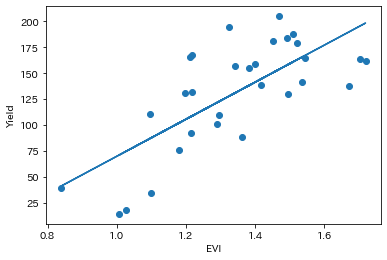

In [34]:
plt.plot(X_linear,b*X_linear+a)
plt.scatter(X_linear,Y_linear)
plt.xlabel('EVI')
plt.ylabel('Yield')

### 2-2-2　予測　 9月2日線形回帰から収量予測

In [36]:
# 実際に収量測定を実施している部分に関しても新しい列に予測値を入れる
# pred_evi_yield= rolled_evi[rolled_evi["15%反収現物重量kg/10a"].isnull()]
X = rolled_evi.iloc[:,28]
X_pred_yield = X.values.reshape(-1, 1)
pred_evi_yield = rolled_evi.copy()
pred_evi_yield['pred_yield'] = reg.predict(X_pred_yield)

Text(0, 0.5, 'Yield')

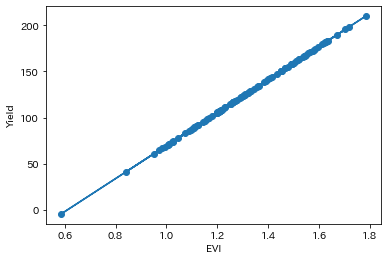

In [37]:
plt.plot(X_pred_yield,b*X_pred_yield+a)
plt.scatter(X_pred_yield,pred_evi_yield['pred_yield'])
plt.xlabel('EVI')
plt.ylabel('Yield')

In [38]:
pred_evi_yield.sort_values("pred_yield")

,圃場番号,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,...,2021-10-13.tiffevi2_median,2021-10-24.tiffevi2_median,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,15%反収現物重量kg/10a,geometry,pred_yield
1,2.0,0.436166,0.471449,0.478470,0.481290,0.483348,0.489033,0.505388,0.508960,0.517242,...,0.734189,0.736386,0.745887,0.743420,0.744661,0.745339,0.742875,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",-4.404377
51,55.0,0.571920,0.603760,0.633393,0.648396,0.654901,0.654475,0.670205,0.682662,0.688157,...,1.294287,1.266140,1.256034,1.235279,1.212017,1.187719,1.152702,39.0,"POLYGON ((140.06037 40.29675, 140.06037 40.296...",40.904715
39,43.0,0.602090,0.617666,0.619679,0.622768,0.623606,0.620944,0.621095,0.617029,0.623274,...,1.388144,1.370061,1.370415,1.355382,1.332454,1.304174,1.265118,NaN,"POLYGON ((140.05985 40.29499, 140.05986 40.294...",60.626318
40,44.0,0.477530,0.506947,0.519107,0.527706,0.530645,0.530447,0.539363,0.538092,0.544868,...,1.457488,1.421385,1.402285,1.366754,1.318763,1.268582,1.209196,NaN,"POLYGON ((140.05930 40.29516, 140.05941 40.295...",64.757583
38,42.0,0.532233,0.561557,0.573963,0.581324,0.582805,0.579893,0.585512,0.583892,0.587541,...,1.503898,1.484628,1.477453,1.449922,1.407057,1.352243,1.281355,NaN,"POLYGON ((140.06095 40.29389, 140.06090 40.293...",66.788970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,73.0,0.856880,0.864792,0.872865,0.885377,0.901231,0.905991,0.923048,0.949385,0.985231,...,1.187076,1.123627,1.080385,1.035024,0.992924,0.960812,0.930793,NaN,"MULTIPOLYGON (((140.06683 40.28277, 140.06718 ...",183.253258
4,5.0,0.767677,0.789252,0.793535,0.797792,0.803739,0.803243,0.812710,0.811115,0.813455,...,1.334537,1.309301,1.289800,1.245366,1.188038,1.119056,1.046696,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272...",189.823395
10,10.0,0.744975,0.766233,0.774407,0.785070,0.796833,0.798120,0.814053,0.814446,0.812134,...,1.436650,1.412686,1.390643,1.343091,1.277574,1.196196,1.107580,164.0,"POLYGON ((140.02158 40.27552, 140.02315 40.275...",195.531091
8,8.0,0.422781,0.448672,0.452413,0.457159,0.459227,0.460729,0.471909,0.472475,0.480926,...,1.447755,1.441256,1.435842,1.404098,1.350136,1.272965,1.179822,162.0,"POLYGON ((140.02314 40.27434, 140.02316 40.274...",198.433779


EVI値が異様に低い場所で終了がマイナスとなってしまっている。　この場所の値を異常値として落とすか？重回帰も行うか？  
重回帰してマイナスで出なかったら重回帰を採用

### 2-2-3　学習　重回帰の場合

#### 2-2-3-0 共通処理

In [39]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [502]:
# このXで全てのEVIではなく、8月7日から9月6日までのデータだけ取得
X_multi = rolled_evi_yield.iloc[:,25:31]
Y = rolled_evi_yield.iloc[:,-2] 

#### 2-2-3-1 Sklearnで全モデル比較

In [504]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from lightgbm import LGBMRegressor
import xgboost as xgb

reg_dict = {"LinearRegression": LinearRegression(),
            "xgboost": xgb.XGBRegressor(),
            "Lightgbm": LGBMRegressor(),
            "Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(), 
            "Polynomial_deg2": Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
            "Polynomial_deg3": Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
            "Polynomial_deg4": Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
            "Polynomial_deg5": Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=3),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(),
            "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1),
            "GaussianProcessRegressor": GaussianProcessRegressor(),
            "SGDRegressor": SGDRegressor(),
            "MLPRegressor": MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
            "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100), 
            "PLSRegression": PLSRegression(n_components=10),
            "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
            "TheilSenRegressor": TheilSenRegressor(random_state=0),
            "RANSACRegressor": RANSACRegressor(random_state=0),
            "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
            "BaggingRegressor": BaggingRegressor(base_estimator=SVR(), n_estimators=10),
            "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
            "VotingRegressor": VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
            "StackingRegressor": StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
            "ARDRegression": ARDRegression(),
            "HuberRegressor": HuberRegressor(),
                    }

In [ ]:
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_regression
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_size = 0.2  # 分割比率
N_trials = 5  # 試行回数

mape_dict = {reg_name:[] for reg_name in reg_dict.keys()}  # 精度の格納庫

for i in range(N_trials):
    print(f"Trial {i+1}")
    x_train, x_test, y_train, y_test = train_test_split(X_multi, Y.ravel(), test_size=test_size, random_state=42)

    for reg_name, reg in reg_dict.items():
        reg.fit(x_train,y_train)
        y_pred = reg.predict(x_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPEを算出
        mape_dict[reg_name].append(mape)  # 格納

# MAPEの平均値でソート
mape_dict_sorted = {key: value for key, value in reversed(sorted(mape_dict.items(), key=lambda x:np.mean(x[1])))}

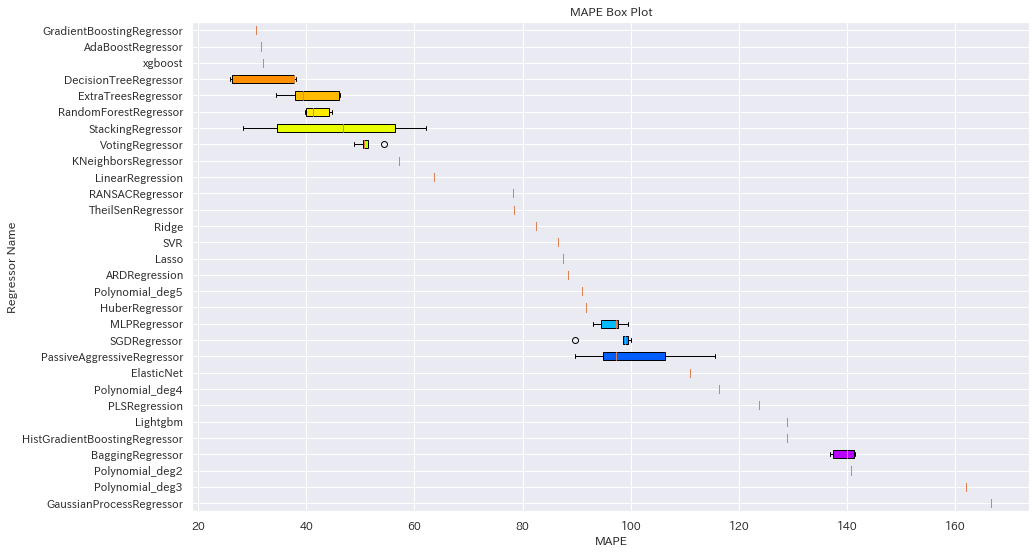

In [509]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plt.rcParams["font.size"] = 18  # フォントサイズを大きくする
scalarMap = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=len(mape_dict)), cmap=plt.get_cmap('gist_rainbow_r'))

plt.figure(figsize=(15,9))
box=plt.boxplot(mape_dict_sorted.values(), vert=False, patch_artist=True,labels=mape_dict_sorted.keys())
for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(scalarMap.to_rgba(i))
plt.title("MAPE Box Plot")
plt.xlabel("MAPE")
plt.ylabel("Regressor Name")
plt.show()

#### 2-2-3-2 Sklearnでリッジ回帰ラッソ回帰勾配ブースティング比較

R-squared_Lasso :  0.011117879919743445
R-squared_Ridge :  0.11550831551649421
###################################################
{'fit_time': array([0.00251842, 0.00145316, 0.00106978, 0.00111461, 0.00119472]), 'score_time': array([0.01334834, 0.00070214, 0.0008018 , 0.00064373, 0.0007081 ]), 'test_p': array([nan, nan, nan, nan, nan]), 'test_r': array([nan, nan, nan, nan, nan]), 'test_f': array([nan, nan, nan, nan, nan])}
###################################################
{'fit_time': array([0.00097466, 0.00071025, 0.00073671, 0.00096893, 0.00079393]), 'score_time': array([0.00096297, 0.00068092, 0.0013113 , 0.00070763, 0.0007441 ]), 'test_p': array([nan, nan, nan, nan, nan]), 'test_r': array([nan, nan, nan, nan, nan]), 'test_f': array([nan, nan, nan, nan, nan])}
###################################################
{'fit_time': array([0.01302576, 0.00845623, 0.00825357, 0.00849295, 0.00907731]), 'score_time': array([0.00231004, 0.00105357, 0.00103235, 0.00116181, 0.00238848]), 'test_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1757, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1544, in precision_re

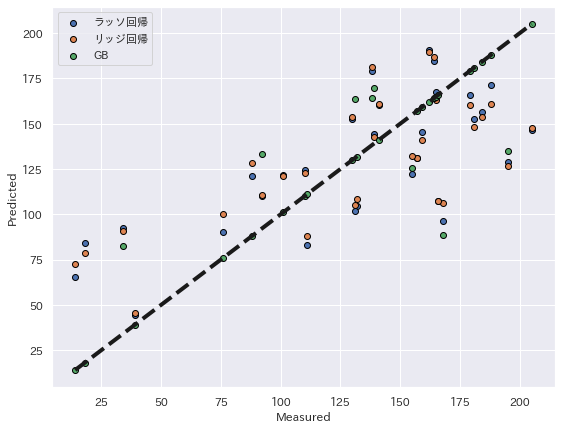

In [533]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def sklearn_calc(labels, params):
    # トレーニングデータとテストデータに分割
    x_train, x_test, y_train, y_test = train_test_split(
    params, labels.ravel(), test_size=0.25)

    # Lasso
    LassoModel = Lasso(alpha=1.0, random_state=0)
    LassoModel.fit(x_train, y_train)

    # Rideg
    RidgeModel = Ridge(alpha=1.0, random_state=0)
    RidgeModel.fit(x_train, y_train)

    # GB
    GBModel =GradientBoostingRegressor(random_state=0)
    GBModel.fit(x_train, y_train)


    scoring = {"p": "precision_macro",
            "r": "recall_macro",
            "f":"f1_macro"}

    # 各モデルによる回帰の評価(決定係数の表示)
    print("R-squared_Lasso : ", LassoModel.score(x_test, y_test))
    print("R-squared_Ridge : ", RidgeModel.score(x_test, y_test))
    # print("R-squared_LinReg : ", LinRegModel.score(x_test, y_test))

    # データセットをランダムに5分割するための変数cvを定義
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    print('###################################################')
    scores = cross_validate(LassoModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    print('###################################################')
    scores = cross_validate(RidgeModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    print('###################################################')
    scores = cross_validate(GBModel, x_train, y_train, cv=cv, scoring=scoring)
    print(scores)
    # print("R-squared_Average_LinReg　: {0:.2f}".format(scores.mean()))

    # matplotでグラフ化
    min_label = labels.ravel().min()
    max_label = labels.ravel().max()
    Lasso_predicted = LassoModel.predict(params)
    Ridge_predicted = RidgeModel.predict(params)
    GBModel_predicted = GBModel.predict(params)

    fig, ax = plt.subplots(figsize=(9,7))
    ax.scatter(labels.ravel(), Lasso_predicted, edgecolors=(0, 0, 0),label='ラッソ回帰')
    ax.scatter(labels.ravel(), Ridge_predicted, edgecolors=(0, 0, 0),label='リッジ回帰')
    ax.scatter(labels.ravel(), GBModel_predicted, edgecolors=(0, 0, 0),label='GB')
    ax.plot([min_label, max_label],
            [min_label, max_label], 'k--', lw=4)
    ax.legend()
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    return
sklearn_calc(Y,X_multi)

#### 2-2-3-3 StatsModelsでラッソ回帰線形回帰の各値の評価

↓Statsmodelは線形回帰モデルの引数のL1_wtに"0"を与えたらRidge回帰"1"を与えたらLasso回帰
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html

In [486]:

# statsmodels　での方法重回帰分析について
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 植生指数は正規化済みなので標準化不要
# scaler = StandardScaler() # インスタンス
# scaler.fit(np.array(interpo_evi_yield)) # 標準化を適応
# df_std = scaler.transform(np.array(interpo_evi_yield)) # 標準化する
# df_std = pd.DataFrame(df_std, columns=interpo_evi_yield.columns) # データフレームに変換
x_pred = X_multi
y_pred = Y

X_con = sm.add_constant(x_pred)

model = sm.OLS(y_pred, X_con) # モデルを作成

# result = model.fit() # モデルを適応
# L1_wt = 1 なのでrasso回帰
result = model.fit_regularized(L1_wt=1, refit=True)
result.summary() # 結果を確認

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        15%反収現物重量kg/10a   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     6.409
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           0.000298
Time:                        12:05:48   Log-Likelihood:                -144.84
No. Observations:                  30   AIC:                             305.7
Df Residuals:                      23   BIC:                             316.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -246.5159     81.985     -3.007      0.006    -416.114     -76.918
2021-08-07.tiffevi2_median -1028.0267   1410.810     -0.729      0.474   -3946.509    1890.455
2021-08-15.tiffevi2_median   704.2319   3255.650      0.216      0.831   -6030.592    7439.056
2021-08-20.tiffevi2_median  -328.0287   4571.814     -0.072      0.943   -9785.546    9129.489
2021-09-02.tiffevi2_median  5236.0043   2972.410      1.762      0.091    -912.894    1.14e+04
2021-09-03.tiffevi2_median -7322.6777   2812.212     -2.604      0.016   -1.31e+04   -1505.173
2021-09-06.tiffevi2_median  2951.4977   1515.057      1.948      0.064    -182.637    6085.633
==============================================================================
Omnibus:                        0.458   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.582
Skew:                           0.100   Prob(JB):                        0.747
Kurtosis:                       2.347   Cond. No.                     3.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ラッソでモデルを適応するためにはfit_regularizedでL1_wt=1を使う必要があるが、このときrefit=Trueも必ず入れないとSummaryが表示されない。理由を考える。

雲の乗ったデータに関してはマイナスの相関が出るようになってしまっている？　雲のフィルタリング機能が必要  
9月2日のデータ以外P値が高い？　9月3日のデータはなぜマイナスの回帰係数なのか？


Statsmodelsの解釈の仕方について
https://dataanablog.com/statistical-methods-in-python-for-beginners-multiple-regression-analysis/

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

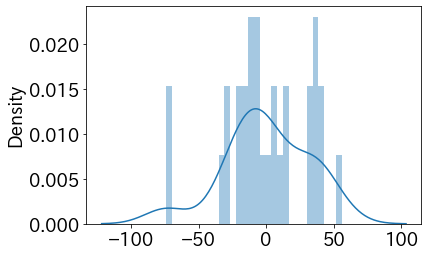

In [308]:
# 回帰分析は残差が正規分布になっていることが望ましいので、プロットして確認
sns.distplot(result.resid,bins=30)

### 2-2-4　予測　複数モデルの比較

In [89]:
rolled_evi_yield

NameError: name 'rolled_evi_yield' is not defined

In [48]:
rolled_evi_yield= rolled_evi.dropna()
X_multi = rolled_evi_yield.iloc[:,25:31]
Y = rolled_evi_yield.iloc[:,-2] 

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

x_train, x_test, y_train, y_test = train_test_split(
    X_multi, Y.ravel(), test_size=0.25)

random_state = 42
# Lasso
LassoModel = Lasso(alpha=1.0, random_state=random_state)
LassoModel.fit(x_train, y_train)

# Rideg
RidgeModel = Ridge(alpha=1.0, random_state=random_state)
RidgeModel.fit(x_train, y_train)

# LinReg
LinRegModel = LinearRegression()
LinRegModel.fit(x_train, y_train)

# GBModel
GBModel =GradientBoostingRegressor(random_state=random_state)
GBModel.fit(x_train, y_train)

# Randomforest
Rfr = RandomForestRegressor(random_state=random_state)
Rfr.fit(x_train, y_train)

GradientBoostingRegressor(random_state=42)

In [51]:
# 実際に収量測定を実施している部分に関しても新しい列に予測値を入れる　isnullの行以外も予測する
# multi_pred_evi_yield= rolled_evi[rolled_evi["15%反収現物重量kg/10a"].isnull()]
multi_pred_evi_yield = rolled_evi.copy(subset)
X_pred_multi = multi_pred_evi_yield.iloc[:,25:31]

multi_pred_evi_yield['Lasso_pred_yield'] = LassoModel.predict(X_pred_multi)
multi_pred_evi_yield['Ridge_pred_yield'] = RidgeModel.predict(X_pred_multi)
multi_pred_evi_yield['GB_pred_yield'] = GBModel.predict(X_pred_multi)

In [52]:
multi_pred_evi_yield

,圃場番号,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,...,2021-10-25.tiffevi2_median,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,15%反収現物重量kg/10a,geometry,Lasso_pred_yield,Ridge_pred_yield,GB_pred_yield
0,1.0,0.538713,0.567764,0.584046,0.594218,0.601011,0.604855,0.623617,0.631276,0.646409,...,1.240164,1.186140,1.117517,1.052343,0.981268,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268...",157.955558,155.835099,130.180940
1,2.0,0.436166,0.471449,0.478470,0.481290,0.483348,0.489033,0.505388,0.508960,0.517242,...,0.745887,0.743420,0.744661,0.745339,0.742875,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",24.402907,28.410647,39.069828
2,3.0,0.883493,0.891488,0.887744,0.887449,0.887648,0.881626,0.875285,0.864969,0.860833,...,1.046357,1.018503,0.992646,0.968487,0.943517,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271...",103.677527,104.903920,98.793765
3,4.0,0.880429,0.882656,0.874078,0.861970,0.855334,0.844842,0.829125,0.808322,0.794469,...,1.330175,1.281007,1.217805,1.146328,1.073730,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271...",175.391881,172.034259,139.157164
4,5.0,0.767677,0.789252,0.793535,0.797792,0.803739,0.803243,0.812710,0.811115,0.813455,...,1.289800,1.245366,1.188038,1.119056,1.046696,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272...",183.490996,179.426344,138.522770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117.0,0.708381,0.701254,0.697157,0.694318,0.690565,0.683963,0.672225,0.669249,0.680947,...,1.242946,1.188112,1.145669,1.118206,1.104321,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287...",151.058660,153.751199,181.940922
110,118.0,0.935511,0.922234,0.914870,0.915502,0.915859,0.911023,0.899846,0.899649,0.910962,...,1.221896,1.189834,1.171546,1.164860,1.163452,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287...",128.065313,130.507224,148.802587
111,119.0,0.850936,0.845031,0.831745,0.824565,0.817702,0.808165,0.790110,0.780420,0.788847,...,1.384214,1.323536,1.264239,1.209597,1.162144,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287...",149.372933,152.515735,181.704752
112,120.0,0.679679,0.681486,0.679577,0.676399,0.672175,0.665587,0.655620,0.649891,0.658054,...,1.536857,1.471074,1.383859,1.287021,1.186355,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287...",164.978962,167.535136,139.924062


In [53]:
# 9月2日衛生画像の線形回帰の予測結果
pred_evi_yield['pred_yield']

0      158.190333
1       -4.404377
2       92.263915
3      179.311575
4      189.823395
          ...    
109    155.017323
110    123.873971
111    153.224163
112    173.694853
113    111.120289
Name: pred_yield, Length: 113, dtype: float64

In [57]:
# 単回帰の予測値と重回帰の予測値を結合して出力
multi_pred_evi_yield['linear_0902_pred_yield'] = pred_evi_yield['pred_yield']

In [56]:
# 元の収量のデータが入ったデータとも結合
# 今の予測では実測値が入っているデータに対しても予測することにしているので今回はパス。
# concat_pd = pd.concat([rolled_evi_yield, multi_pred_evi_yield])

In [59]:
multi_pred_evi_yield

,圃場番号,2021-06-25.tiffevi2_median,2021-06-27.tiffevi2_median,2021-06-28.tiffevi2_median,2021-06-29.tiffevi2_median,2021-06-30.tiffevi2_median,2021-07-01.tiffevi2_median,2021-07-02.tiffevi2_median,2021-07-07.tiffevi2_median,2021-07-14.tiffevi2_median,...,2021-11-01.tiffevi2_median,2021-11-02.tiffevi2_median,2021-11-06.tiffevi2_median,2021-11-07.tiffevi2_median,15%反収現物重量kg/10a,geometry,Lasso_pred_yield,Ridge_pred_yield,GB_pred_yield,linear_0902_pred_yield
0,1.0,0.538713,0.567764,0.584046,0.594218,0.601011,0.604855,0.623617,0.631276,0.646409,...,1.186140,1.117517,1.052343,0.981268,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268...",157.955558,155.835099,130.180940,158.190333
1,2.0,0.436166,0.471449,0.478470,0.481290,0.483348,0.489033,0.505388,0.508960,0.517242,...,0.743420,0.744661,0.745339,0.742875,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",24.402907,28.410647,39.069828,-4.404377
2,3.0,0.883493,0.891488,0.887744,0.887449,0.887648,0.881626,0.875285,0.864969,0.860833,...,1.018503,0.992646,0.968487,0.943517,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271...",103.677527,104.903920,98.793765,92.263915
3,4.0,0.880429,0.882656,0.874078,0.861970,0.855334,0.844842,0.829125,0.808322,0.794469,...,1.281007,1.217805,1.146328,1.073730,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271...",175.391881,172.034259,139.157164,179.311575
4,5.0,0.767677,0.789252,0.793535,0.797792,0.803739,0.803243,0.812710,0.811115,0.813455,...,1.245366,1.188038,1.119056,1.046696,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272...",183.490996,179.426344,138.522770,189.823395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117.0,0.708381,0.701254,0.697157,0.694318,0.690565,0.683963,0.672225,0.669249,0.680947,...,1.188112,1.145669,1.118206,1.104321,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287...",151.058660,153.751199,181.940922,155.017323
110,118.0,0.935511,0.922234,0.914870,0.915502,0.915859,0.911023,0.899846,0.899649,0.910962,...,1.189834,1.171546,1.164860,1.163452,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287...",128.065313,130.507224,148.802587,123.873971
111,119.0,0.850936,0.845031,0.831745,0.824565,0.817702,0.808165,0.790110,0.780420,0.788847,...,1.323536,1.264239,1.209597,1.162144,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287...",149.372933,152.515735,181.704752,153.224163
112,120.0,0.679679,0.681486,0.679577,0.676399,0.672175,0.665587,0.655620,0.649891,0.658054,...,1.471074,1.383859,1.287021,1.186355,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287...",164.978962,167.535136,139.924062,173.694853


In [60]:
# 不要なEVIを落とす　計算に利用したEVIのみ表示　8月7日から9月6日
drop_pred_evi_yield = multi_pred_evi_yield[['圃場番号', 
       '2021-08-07.tiffevi2_median', '2021-08-15.tiffevi2_median',
       '2021-08-20.tiffevi2_median', '2021-09-02.tiffevi2_median',
       '2021-09-03.tiffevi2_median', '2021-09-06.tiffevi2_median',
       '15%反収現物重量kg/10a', 'geometry', 'Lasso_pred_yield', 'Ridge_pred_yield',
       'GB_pred_yield', 'linear_0902_pred_yield']].copy()

In [61]:
drop_pred_evi_yield

,圃場番号,2021-08-07.tiffevi2_median,2021-08-15.tiffevi2_median,2021-08-20.tiffevi2_median,2021-09-02.tiffevi2_median,2021-09-03.tiffevi2_median,2021-09-06.tiffevi2_median,15%反収現物重量kg/10a,geometry,Lasso_pred_yield,Ridge_pred_yield,GB_pred_yield,linear_0902_pred_yield
0,1.0,1.267065,1.351999,1.422913,1.494418,1.555549,1.607466,130.0,"POLYGON ((140.02161 40.26848, 140.02316 40.268...",157.955558,155.835099,130.180940,158.190333
1,2.0,0.544740,0.554224,0.567704,0.586414,0.607875,0.638343,NaN,"POLYGON ((140.02144 40.27122, 140.02245 40.271...",24.402907,28.410647,39.069828,-4.404377
2,3.0,0.996669,1.038014,1.083949,1.126255,1.169041,1.213271,NaN,"POLYGON ((140.02276 40.27167, 140.02343 40.271...",103.677527,104.903920,98.793765,92.263915
3,4.0,1.347240,1.447308,1.533805,1.612369,1.681535,1.734218,NaN,"POLYGON ((140.02132 40.27196, 140.02333 40.271...",175.391881,172.034259,139.157164,179.311575
4,5.0,1.374422,1.488161,1.586250,1.671072,1.742455,1.791612,138.0,"POLYGON ((140.02119 40.27221, 140.02338 40.272...",183.490996,179.426344,138.522770,189.823395
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,117.0,1.305627,1.378916,1.428184,1.476699,1.505469,1.546381,NaN,"POLYGON ((140.08602 40.28704, 140.08671 40.287...",151.058660,153.751199,181.940922,155.017323
110,118.0,1.180394,1.225282,1.259529,1.302780,1.334956,1.386186,NaN,"POLYGON ((140.08593 40.28709, 140.08662 40.287...",128.065313,130.507224,148.802587,123.873971
111,119.0,1.305647,1.373583,1.420115,1.466685,1.493728,1.533601,NaN,"POLYGON ((140.08575 40.28722, 140.08643 40.287...",149.372933,152.515735,181.704752,153.224163
112,120.0,1.375648,1.464412,1.527596,1.581003,1.611127,1.643738,NaN,"POLYGON ((140.08553 40.28736, 140.08618 40.287...",164.978962,167.535136,139.924062,173.694853


In [62]:
# gpd で出力
drop_pred_evi_yield = gpd.GeoDataFrame(drop_pred_evi_yield, geometry='geometry')
drop_pred_evi_yield.to_file('/workspaces/akita_daizu/data/収量予測_120圃場.geojson', driver="GeoJSON")  

### 2-2-5　予測　Oputuna LGBM

In [534]:
# 収量のあるデータのみで学習
rolled_evi_yield= rolled_evi.dropna()

In [535]:
# このXで全てのEVIではなく、8月7日から9月6日までのデータだけ取得
X_multi = rolled_evi_yield.iloc[:,25:31]
Y = rolled_evi_yield.iloc[:,-2] 

In [538]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import optuna

In [ ]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_multi, Y, test_size=0.25, random_state = 42)
    dtrain = lgb.Dataset(train_x, label=train_y)
 
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Best trial: {'lambda_l1': 3.117668913553932e-07, 'lambda_l2': 9.38502819112676, 'num_leaves': 95, 'feature_fraction': 0.8088697228912456, 'bagging_fraction': 0.5175916730604163, 'bagging_freq': 4, 'min_child_samples': 50}

In [543]:
import matplotlib.pyplot as plt
X_train, X_valid, y_train, y_valid = train_test_split(X_multi, Y, test_size=0.3,shuffle=True, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

evals_result = {} 
params = {
    'lambda_l1': 3.117668913553932e-07, 'lambda_l2': 9.38502819112676, 'num_leaves': 95, 'feature_fraction': 0.8088697228912456, 'bagging_fraction': 0.5175916730604163, 'bagging_freq': 4, 'min_child_samples': 50
    ,'objective': 'binary'
}

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=500000,
    early_stopping_rounds=10,
    evals_result = evals_result
)

multi_pred_evi_yield= rolled_evi[rolled_evi["15%反収現物重量kg/10a"].isnull()]
X_pred_multi = pred_evi_yield.iloc[:,25:31]

y_pred = model.predict(X_pred_multi, num_iteration=model.best_iteration)

[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 21, number of negative: 0
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 21, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split re

### 2-2-5　予測　Pipeline RF GB XGB

In [ ]:
# 予測データ結合用DFの作成
pred_df = 
target_col = 'pred_yield'

In [ ]:
'''
ランダムフォレスト、勾配ブースティング、XGBoostの3モデル比較
交差検証 Repeated Kfold
Gridsearch n_estimatorsとmax_depth　estimatorsは指定しなくても良いと思う early stopを入れる
'''

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
import xgboost

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=True)

# build pipeline
def build_pipelines():
    random_seed = 42
    pipelines = {
        'Rfr':
            Pipeline([('scl',StandardScaler()),
                    ('est',RandomForestRegressor(random_state=random_seed))]),
        'Gbr':
            Pipeline([('scl',StandardScaler()),
                    ('est',GradientBoostingRegressor(random_state=random_seed))]),
        'Xgb':
            Pipeline([('scl',StandardScaler()),
                    ('est',xgboost.XGBRegressor(random_state=random_seed))])
    }
    return(pipelines)

def pipe_score_predict(XX, YY, pred_df):
    train_x, test_x, train_y, test_y = train_test_split(
        XX, YY, test_size=0.3, random_state=42, shuffle=True)

    
    scores = pd.DataFrame()
    preds_df = pd.DataFrame()

    pipelines =  build_pipelines()

    for pipe_name, pipeline in pipelines.items():
        rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
        rf_tune_params = {'est__n_estimators': [8, 16, 32, 64, 128, 256, 512],
                        'est__max_depth': [2,4,6]}
        clf_pipeline = GridSearchCV(pipeline,rf_tune_params, cv=rkf, refit=True)
        clf_pipeline.fit(train_x, train_y)
        scores.loc[pipe_name,'train_rmse'] = rmse(train_y, clf_pipeline.predict(train_x))
        scores.loc[pipe_name,'test_rmse'] = rmse(test_y, clf_pipeline.predict(test_x))
        scores.loc[pipe_name,'train_r2_score'] = r2_score(train_y, clf_pipeline.predict(train_x))
        scores.loc[pipe_name,'test_r2_score'] = r2_score(test_y, clf_pipeline.predict(test_x))

        best_model = clf_pipeline.best_estimator_
        
        #3モデルの予測値をｄｆに格納
        preds_df["pred" + pipe_name + target_col] = best_model.predict(pred_df[band_cols])

    #　3モデル予測値の平均を予測値として代入
    pred_df["pred" + target_col] = preds_df.mean(axis=1)

    
    return(scores, pred_df)